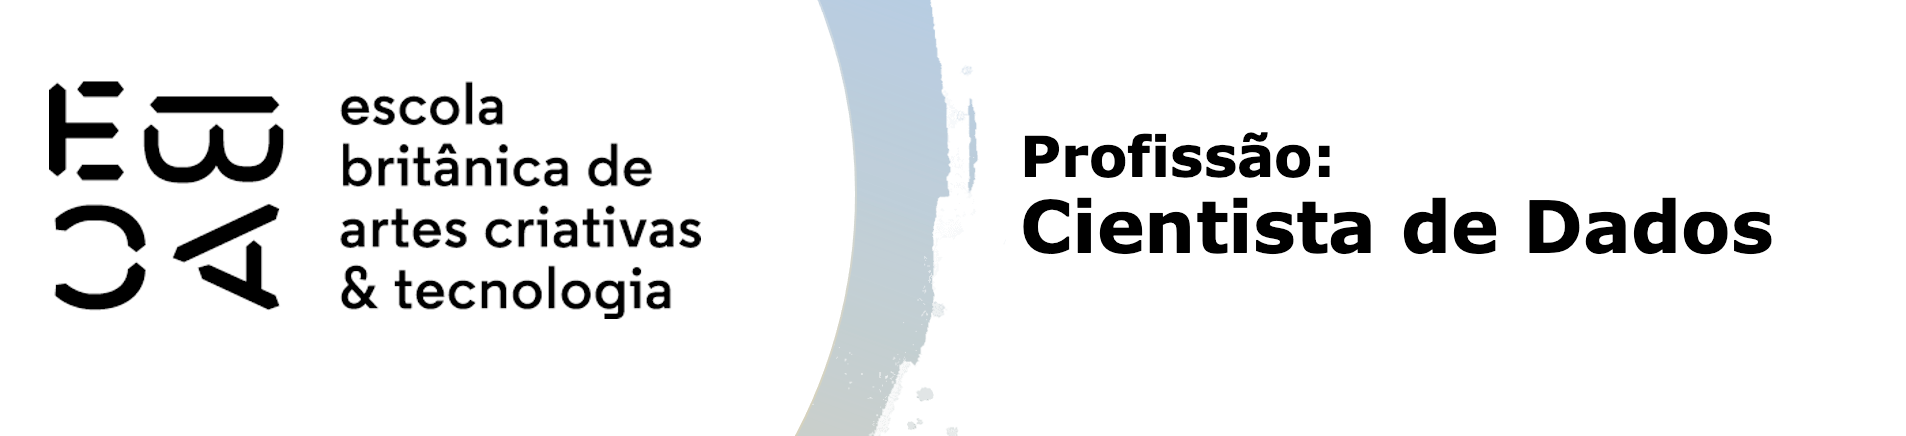

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

from IPython.display import display

import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.interpolate import interp1d 

import statsmodels.api as sm

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [2]:
# Substituí-se Missing pela média como feito anteriormente:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df['log_renda'] = np.log(df['renda'])

In [3]:
# Dividi-se a base de treino e teste, como mencionado no módulo 34, os últimos 3 meses para teste:
holdout = df[pd.to_datetime(df.data_ref) > max(pd.to_datetime(df.data_ref)) - pd.DateOffset(months=3)]
display(holdout.data_ref.unique())

train =df[pd.to_datetime(df.data_ref) <= max(pd.to_datetime(df.data_ref)) - pd.DateOffset(months=3)]
display(train.data_ref.unique())

array(['2016-01-01', '2016-02-01', '2016-03-01'], dtype=object)

array(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
       '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
       '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
      dtype=object)

In [4]:
# Removendo as colunas do index
holdout = holdout.reset_index(drop=True)
holdout = holdout.drop(['index'], axis = 1)

train = train.reset_index(drop=True)
train = train.drop(['index'], axis = 1)

In [5]:
# Apesar de termos tido melhor resultados de modelagem ao analisarmos regressão segmentada ou lowless, no módulo anterior, essa análise 

print("2. Regressão segmentadas:")

C1 = 7.02
C2 = 7.735
C3 = 11.397
C4 = 13.87
C5 = 17.529

# Variáveis segmentadas
train['X1_1'] = (train.tempo_emprego <= C1)*train.tempo_emprego + (train.tempo_emprego > C1)*C1
train['X1_2'] = (train.tempo_emprego <= C1)*0 + ((train.tempo_emprego > C1) & (train.tempo_emprego <= C2))*(train.tempo_emprego - C1) + (train.tempo_emprego > C2)*(C2 - C1)
train['X1_3'] = (train.tempo_emprego <= C2)*0 + ((train.tempo_emprego > C2) & (train.tempo_emprego <= C3))*(train.tempo_emprego - C2) + (train.tempo_emprego > C3)*(C3 - C2)
train['X1_4'] = (train.tempo_emprego <= C3)*0 + ((train.tempo_emprego > C3) & (train.tempo_emprego <= C4))*(train.tempo_emprego - C3) + (train.tempo_emprego > C4)*(C4 - C3)
train['X1_5'] = (train.tempo_emprego <= C4)*0 + (train.tempo_emprego > C4)*(train.tempo_emprego - C4)

res_seg = smf.ols('log_renda ~ X1_1 + X1_2 + X1_3 + X1_4 + X1_5', data=train).fit()

print(f'R-quadrado: {res_seg.rsquared:.2%}')

res_seg.summary()

2. Regressão segmentadas:
R-quadrado: 42.34%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 8.813e+04
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:01:25   Log-Likelihood:            -8.0504e+05
No. Observations:              600000   AIC:                         1.610e+06
Df Residuals:                  599994   BIC:                         1.610e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3010      0.003   2404.991      0.000       8.294       8.308
X1_1           0.1363      0.001    161.467      0.000       0.135       0.138
X1_2          -0.2104      0.006    -35.027      0.000      -0.222      -0.199
X1_3           0.2109      0.002    122.715      0.000       0.207       0.214
X1_4           0.1239      0.003     41.573      0.000       0.118       0.130
X1_5           0.1204      0.001    227.518      0.000       0.119       0.121
==============================================================================
Omnibus:                      889.164   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              786.510
Skew:                          -0.045   Prob(JB):                    1.63e-171
Kurtosis:                       2.847   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

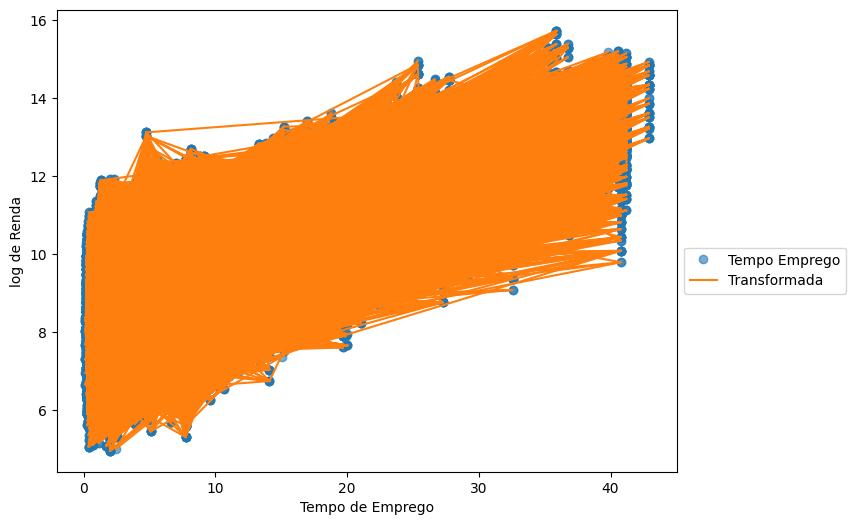

In [6]:
# Considerando que a melhor análise considera o log da renda para cálculos conhecemos o gráfico em relação ao tempo de emprego, sem transfomação e o gráfico considerando 
# a transformação anteriormente estudada
# Ajusta limites do Agg
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['path.simplify_threshold'] = 1.0

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(train['tempo_emprego'], round(train['log_renda'], 3), "o", label="Tempo Emprego", alpha=0.6)

ax.plot(train['tempo_emprego'], round(train['log_renda'], 3), "-", label="Transformada", alpha=1)

plt.ylabel("log de Renda")
plt.xlabel("Tempo de Emprego")
ax.legend(bbox_to_anchor=(1, 0.5))

plt.show()

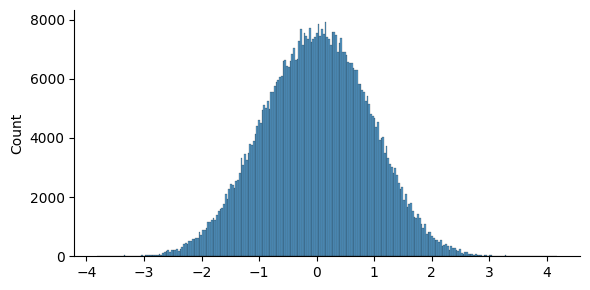

In [7]:
# Distribuição normal
sns.displot(res_seg.resid, height = 3, aspect = 2)

Os resíduos do modelo analisado seguem de forma muito aproximada a disrtribuição normal, mostrando um aspecto quase que perfeito de sino, em que há poucas variações das colunas de valor mais alto que o padrão do desenho. 

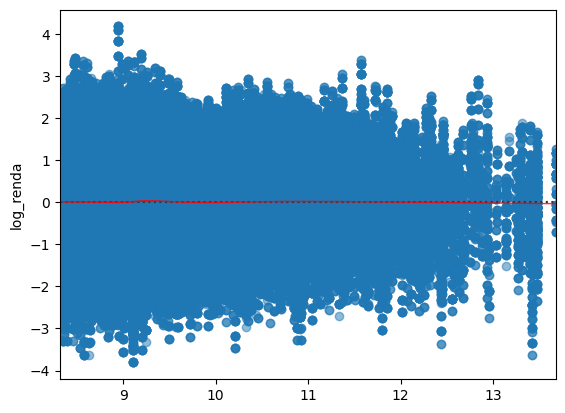

In [8]:
# Resíduos 
sns.residplot(x=res_seg.predict(), y=train['log_renda'], data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

A comparação entre resíduos e valores preditos de log de renda mostrada no gráfico anterior apresenta uma padronização entre os valores e com poucas aparições de outliers. A linha de tendência está centrada no gráfico  apesar de haver uma grande concentração deles ao longo de todo o modelo.

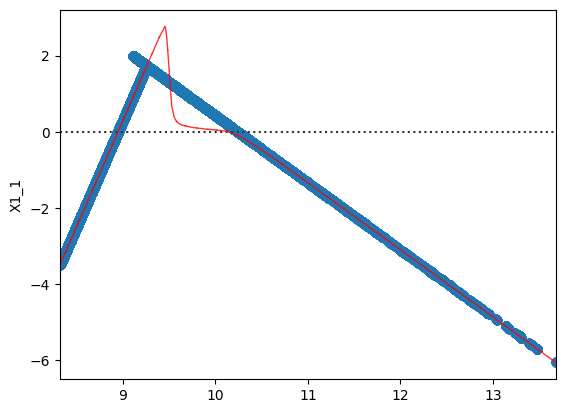

In [9]:
sns.residplot(x=res_seg.predict(), y='X1_1', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

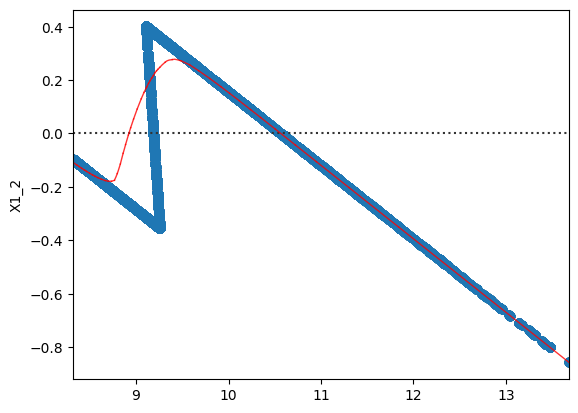

In [10]:
sns.residplot(x=res_seg.predict(), y='X1_2', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

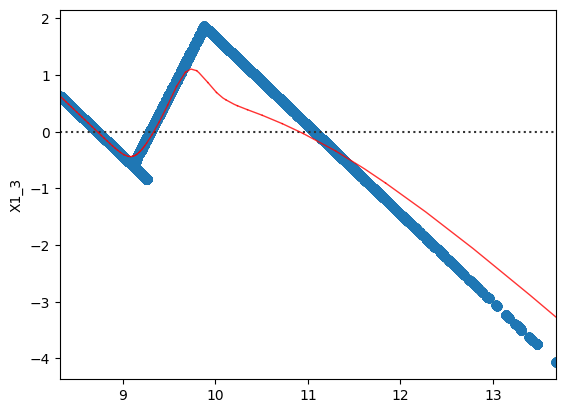

In [11]:
sns.residplot(x=res_seg.predict(), y='X1_3', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

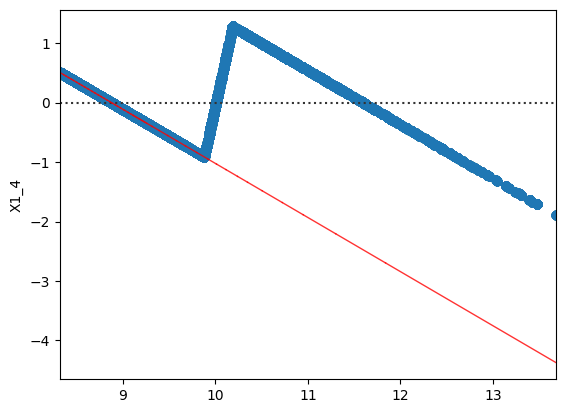

In [12]:
sns.residplot(x=res_seg.predict(), y='X1_4', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

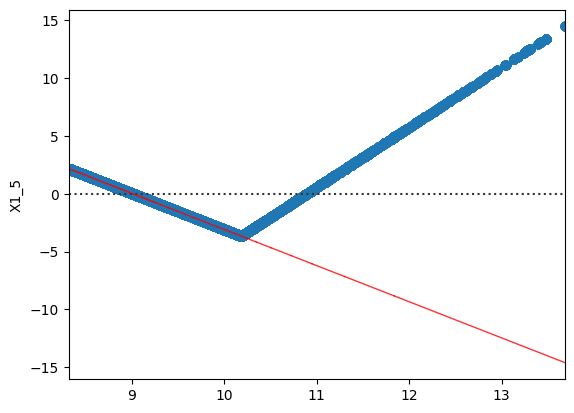

In [13]:
sns.residplot(x=res_seg.predict(), y='X1_5', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

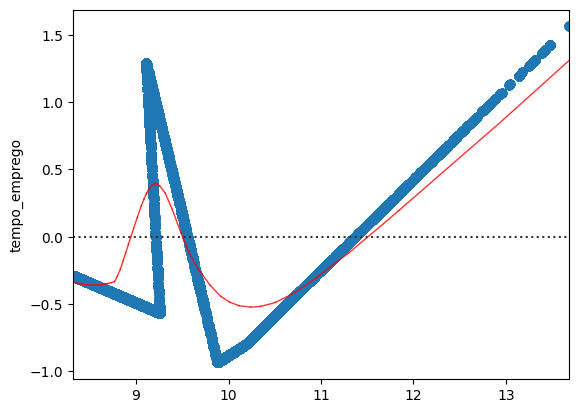

In [14]:
sns.residplot(x=res_seg.predict(), y='tempo_emprego', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

Observando os gráficos anteriores comparativos entre os valores preditos e os valores das variáveis da equação, observamos uma tedência mais clara ao longo dos gráficos comparativos de X1_1 e X1_2. Já observando os outros gráficos observamos uma tendência em partes da análise mas no em uma totalidade dela.

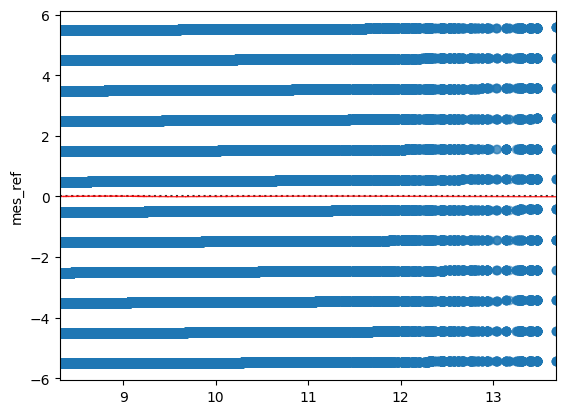

In [15]:
#Resíduos por mês de referência.
#Mês de referência 
train['mes_ref'] = pd.to_datetime(train['data_ref']).dt.month

sns.residplot(x=res_seg.predict(), y='mes_ref', data = train, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

Analisando o gráfico acima percebemos que não parece haver uma grande variação entre o valor de log de renda considerando o mês de referência analisado.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

<Axes: xlabel='tempo_emprego', ylabel='log_renda'>

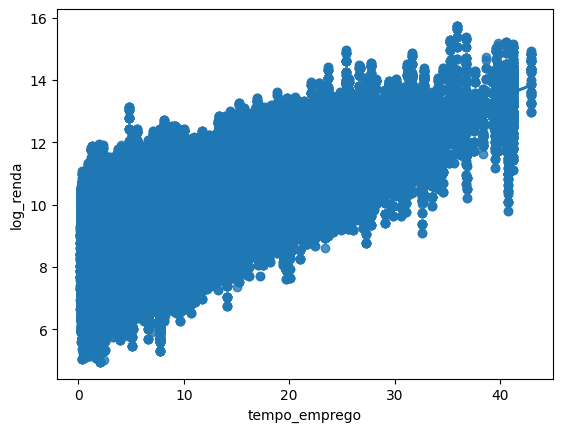

In [16]:
fig, ax = plt.subplots()

sns.regplot(x = 'tempo_emprego', y = train['log_renda'], data=train, ax=ax)

Se percebe que há uma grande concentração de de dados ao longo de todo o gráfico, mas ainda são percebidos alguns outliers, de valores tanto superiores quanto inferiores ao padronizado.

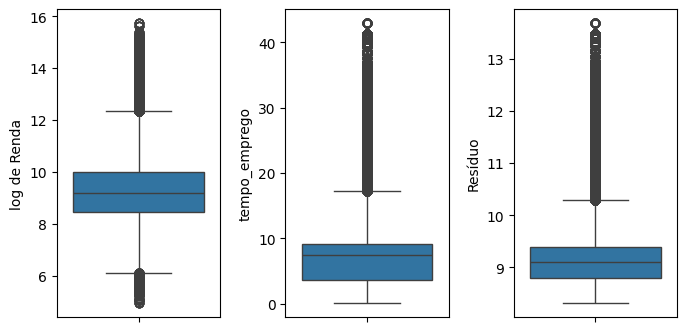

In [17]:
fix, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = train['log_renda'],data=train, ax=ax[0])
sns.boxplot(y = 'tempo_emprego',data=train, ax=ax[1])
sns.boxplot(y = res_seg.predict() ,data=train, ax=ax[2]);

ax[0].set_ylabel('log de Renda')
ax[2].set_ylabel('Tempo de emprego')
ax[2].set_ylabel('Resíduo');

O terceiro gráfico, o de resíduos mostra uma grande concentração e valores de outliers.

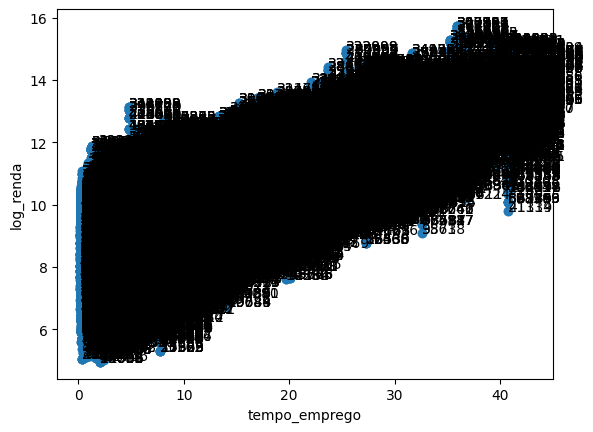

In [18]:
fig, ax = plt.subplots()

sns.regplot(x = 'tempo_emprego', y = 'log_renda', data = train, ax = ax)

for i, txt in enumerate (train.index.values):
    ax.annotate(str(txt), (train.loc[i, 'tempo_emprego'], train.loc[i, 'log_renda']))

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [19]:
var = ['sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'qtd_filhos',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia',
    'idade',
    'tempo_emprego',
    'qt_pessoas_residencia']

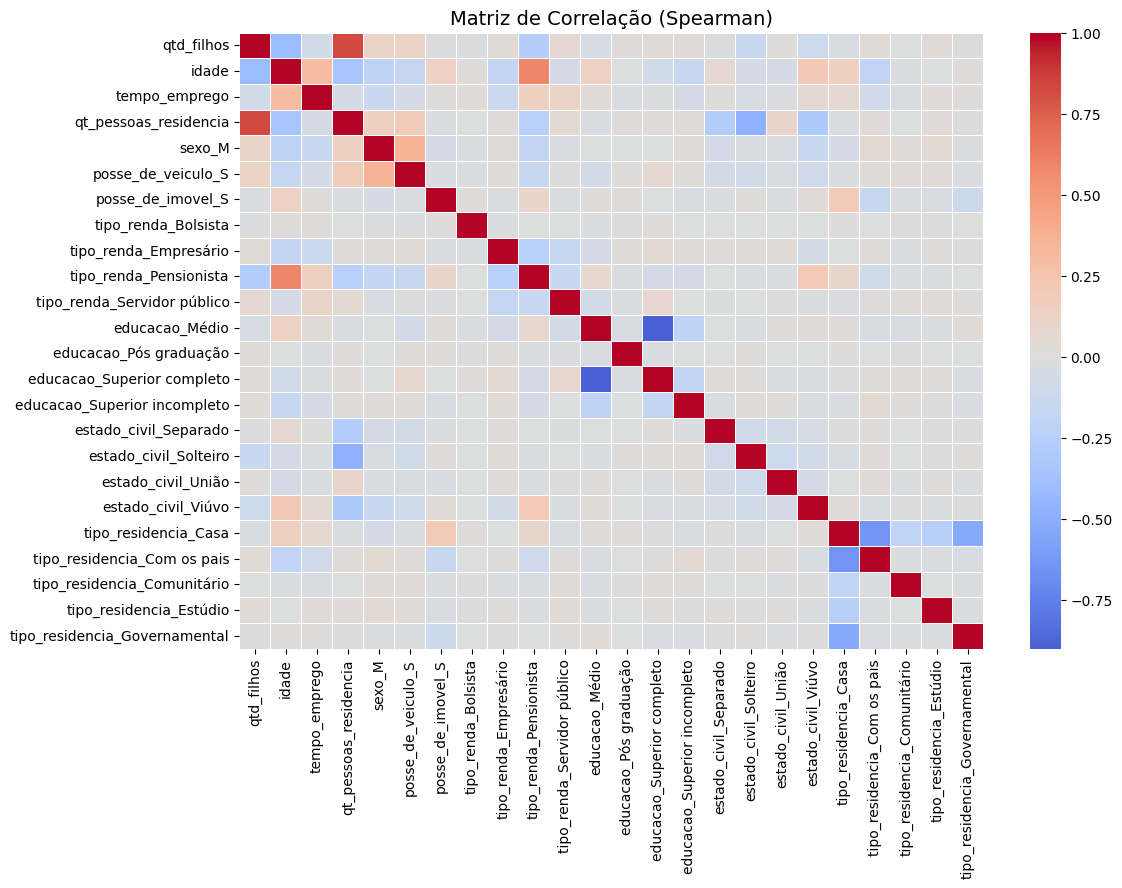

In [20]:
rel = pd.get_dummies(holdout[var], drop_first=True).corr(method='spearman')
plt.figure(figsize=(12,8))
sns.heatmap(rel, annot=False, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Matriz de Correlação (Spearman)", fontsize=14)
plt.show()

In [21]:
dummies = pd.get_dummies(holdout[var], drop_first=True)
dummies = dummies.astype(float)

print("O resultado do agrupamento é:")
dummies.head()

O resultado do agrupamento é:


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,61.0,7.746165,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,27.0,9.301370,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,38.0,10.967123,5.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,35.0,5.553425,5.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,63.0,9.265753,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [23]:
vars_vif = pd.DataFrame()
vars_vif["Feature"] = dummies.columns
vars_vif["VIF Factor"] = [vif(dummies.values, i) 
                          for i in range(dummies.shape[1])]

print("O resultado da análise é:",vars_vif.round(2))

O resultado da análise é:                           Feature  VIF Factor
0                      qtd_filhos       34.35
1                           idade       34.46
2                   tempo_emprego        3.02
3           qt_pessoas_residencia      239.10
4                          sexo_M        1.82
5              posse_de_veiculo_S        1.96
6               posse_de_imovel_S        3.23
7             tipo_renda_Bolsista        1.00
8           tipo_renda_Empresário        1.48
9          tipo_renda_Pensionista        2.19
10    tipo_renda_Servidor público        1.20
11                 educacao_Médio       43.74
12         educacao_Pós graduação        1.10
13     educacao_Superior completo       38.35
14   educacao_Superior incompleto        4.32
15          estado_civil_Separado        3.43
16          estado_civil_Solteiro        5.80
17             estado_civil_União        1.13
18             estado_civil_Viúvo        2.94
19           tipo_residencia_Casa       61.74
20    ti

Como esperado a quantidade de pessoas por resedência e o número de filhos tem grande correlação quando observada a matriz de Spearman. Também, podemos notar uma relação positiva mediana entre o estado civil e a quantidade de pessoas morando na residência e idade e tipo de renda. Percebemos um relacionamento negativo mediano entre idade  e quantidade de filhos, idade e quantidade de pessoas na residência e estado civil e quantidade de pessoas na residência. Essas relações são notadas pelo valor referente na célula da matriz se aproximando do módulo de 1.

Dessa forma, entre essas variáveis, serão mantidos apenas quantidade de filhos, estado civil e idade.

Para a análise VIF utilizo o agrupamento de dados em dummies

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [24]:
var = ['sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'qtd_filhos',
    'educacao',
    'estado_civil',
    'tipo_residencia',
    'idade',
    'tempo_emprego']
dummies = pd.get_dummies(holdout[var], drop_first=True)
dummies = dummies.astype(float)

print("O resultado do agrupamento é:")
dummies.head()


O resultado do agrupamento é:


,qtd_filhos,idade,tempo_emprego,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,61.0,7.746165,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,27.0,9.301370,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,38.0,10.967123,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,35.0,5.553425,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,63.0,9.265753,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [25]:
# Cálculo do VIF
vars_vif = pd.DataFrame()
vars_vif["Feature"] = dummies.columns
vars_vif["VIF Factor"] = [vif(dummies.values, i) 
                          for i in range(dummies.shape[1])]

print("O resultado da análise é:",
vars_vif.round(2))

print("Percebemos um altissimo valor de VIF para variáveis 'idade', 'tipo_residencia' e 'educacao' então as excluiremos dapróxima análise.")

O resultado da análise é:                           Feature  VIF Factor
0                      qtd_filhos        1.58
1                           idade       20.67
2                   tempo_emprego        2.83
3                          sexo_M        1.79
4              posse_de_veiculo_S        1.95
5               posse_de_imovel_S        3.21
6                  educacao_Médio       23.71
7          educacao_Pós graduação        1.05
8      educacao_Superior completo       20.61
9    educacao_Superior incompleto        2.62
10          estado_civil_Separado        1.10
11          estado_civil_Solteiro        1.22
12             estado_civil_União        1.12
13             estado_civil_Viúvo        1.13
14           tipo_residencia_Casa       42.11
15    tipo_residencia_Com os pais        2.86
16    tipo_residencia_Comunitário        1.18
17        tipo_residencia_Estúdio        1.34
18  tipo_residencia_Governamental        2.40
Percebemos um altissimo valor de VIF para variáveis 'i

In [26]:
var = ['sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'qtd_filhos',
    'estado_civil',
    'tempo_emprego']
dummies = pd.get_dummies(holdout[var], drop_first=True)
dummies = dummies.astype(float)

print("O novo resultado do agrupamento é:")
dummies.head()

O novo resultado do agrupamento é:


,qtd_filhos,tempo_emprego,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo
0,0.0,7.746165,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,9.301370,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,10.967123,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,3.0,5.553425,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,9.265753,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
vars_vif = pd.DataFrame()
vars_vif["Feature"] = dummies.columns
vars_vif["VIF Factor"] = [vif(dummies.values, i) 
                          for i in range(dummies.shape[1])]

print("E o atual resultado da análise é:",
vars_vif.round(2))

print("O resultado calculado mostra que as variáveis 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'estado_civil' e 'tempo_emprego' tem relevância para a análise da venda")

E o atual resultado da análise é:                  Feature  VIF Factor
0             qtd_filhos        1.32
1          tempo_emprego        1.90
2                 sexo_M        1.66
3     posse_de_veiculo_S        1.80
4      posse_de_imovel_S        2.11
5  estado_civil_Separado        1.06
6  estado_civil_Solteiro        1.13
7     estado_civil_União        1.07
8     estado_civil_Viúvo        1.07
O resultado calculado mostra que as variáveis 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'estado_civil' e 'tempo_emprego' tem relevância para a análise da venda
